<a href="https://colab.research.google.com/github/Giraldo0712/TAM_2025_2/blob/main/Trabajo_en_clase_TAM_28_09_25_Opt_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Trabajo en clase 28/09/25
## Ismael Cortez Ramirez
## Santiago Alzate Serna
## Juan Camilo Giraldo Jimenez
## Mateo Palacios Lopez

#Sin optimizacion

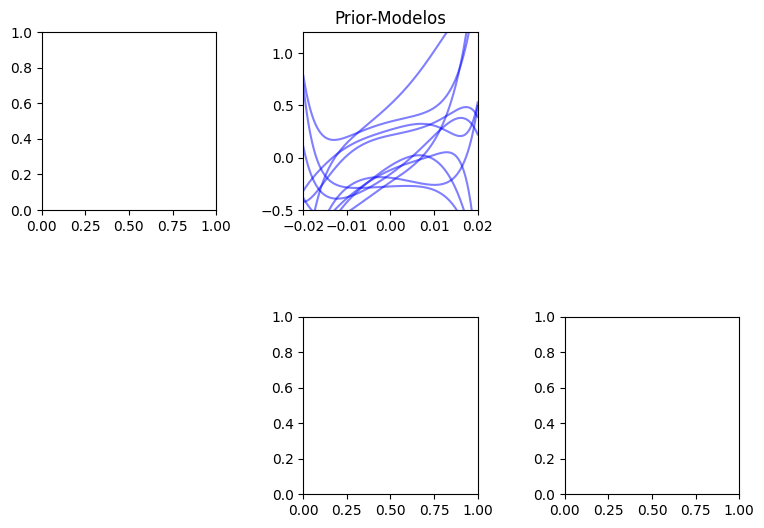

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from scipy.stats import multivariate_normal as mn

# ==============================
# 1. Generar datos sinc + ruido
# ==============================
f0 = 60
N = 300
t_axis = np.linspace(-0.02, 0.02, N)   # eje temporal

# señal sinc limpia
y_clean = np.sin(2*np.pi*f0*t_axis)/(2*np.pi*f0*t_axis)
y_clean[t_axis==0] = 1   # corregir singularidad

# Ruido Gaussiano Blanco (WGN)
noise_power = 0.02   # <-- controla intensidad del ruido
y_noisy = y_clean + np.sqrt(noise_power)*np.random.randn(N)

# ==============================
# 2. Base polinómica grado 9
# ==============================
deg = 9
t_scaled = t_axis / np.max(np.abs(t_axis))  # escalar para mejor condición
X = np.vstack([t_scaled**d for d in range(deg+1)]).T

tt = y_clean
t_obs = y_noisy

# ==============================
# 3. Funciones auxiliares
# ==============================
def my_linregsyn(mu,Sigma,axes,xmin=-0.02,xmax=0.02,Nmod=10,xlim=None,ylim=None):
    """Graficar modelos muestreados de la distribución de pesos"""
    pdfw = mn(mu,Sigma)
    wmod = pdfw.rvs(size=Nmod)
    Xlin = np.linspace(xmin,xmax,200)
    Xlin_scaled = Xlin / np.max(np.abs(t_axis))  # escalar igual que antes
    Xphi = np.vstack([Xlin_scaled**d for d in range(deg+1)]).T
    Ymod = Xphi.dot(wmod.T)
    axes.plot(Xlin,Ymod,c='b',alpha=0.5)
    if xlim: axes.set_xlim(xlim)
    if ylim: axes.set_ylim(ylim)

def my_posterior_update(X,t,sig_eta,sig_w,tol=1e-10):
    lambdaR = sig_eta/sig_w
    SNinv = X.T.dot(X) + lambdaR*np.eye(X.shape[1])
    val,vec = np.linalg.eigh(SNinv)
    ind = val > tol
    SN = vec[:,ind].dot(np.diag(1/val[ind])).dot(vec[:,ind].T)
    mN = np.squeeze(SN.dot(X.T.dot(t)))
    return mN,SN

def my_predictiva_update(xnew,mN,SN,sig_eta):
    mnew = xnew.dot(mN)
    signew = np.diag(sig_eta*np.eye(xnew.shape[0]) + xnew.dot(SN).dot(xnew.T))
    return mnew, signew

# ==============================
# 4. Prior inicial (10 parámetros)
# ==============================
mu_w = np.zeros(deg+1)
sig_w = 0.1   # más fuerte (regularización)
S_w = sig_w*np.eye(len(mu_w))
sig_eta = noise_power * 0.5  # confiar más en datos

# índices aleatorios de muestreo
ind = np.random.permutation(X.shape[0])

# límites gráficos
xlim = [t_axis.min(), t_axis.max()]
ylim = [-0.5,1.2]

# ==============================
# 5. Animación 2×3
# ==============================
fig, ax = plt.subplots(2, 3,figsize=(9,6))
ax[0,2].axis('off')
ax[1,0].axis('off')  # quitamos pdf de pesos
ax[1,2].set_title("Predictiva")

def update(i):
    for r in range(2):
        for c in range(3):
            ax[r,c].clear()
    ax[0,2].axis('off')
    ax[1,0].axis('off')

    # --- Prior modelos ---
    my_linregsyn(mu_w,S_w,axes=ax[0,1],xlim=xlim,ylim=ylim)
    ax[0,1].set_title('Prior-Modelos')

    # --- Posterior con i datos ---
    if i>0:
        mN,SN = my_posterior_update(X[ind[:i]],t_obs[ind[:i]],sig_eta,sig_w,tol=1e-10)
        my_linregsyn(mN,SN,axes=ax[1,1],xlim=xlim,ylim=ylim)
        ax[1,1].scatter(X[ind[:i],1],t_obs[ind[:i]],c='r',s=10)
        ax[1,1].set_title('Posterior-Modelos')

        # --- Predictiva ---
        Xtest_scaled = t_axis / np.max(np.abs(t_axis))
        Xtest = np.vstack([Xtest_scaled**d for d in range(deg+1)]).T
        mnew,snew = my_predictiva_update(Xtest,mN,SN,sig_eta)

        ax[1,2].plot(t_axis,tt,'g',label='sinc limpia')
        ax[1,2].scatter(t_axis[ind[:i]],t_obs[ind[:i]],c='r',s=10,label='datos')
        ax[1,2].plot(t_axis,mnew,'b',label='media pred.')
        ax[1,2].fill_between(t_axis, mnew-2*snew, mnew+2*snew, alpha=0.3)
        ax[1,2].set_xlim(xlim)
        ax[1,2].set_ylim(ylim)
        ax[1,2].legend()
        ax[1,2].set_title('Predictiva')

    plt.subplots_adjust(wspace=0.5,hspace=0.6)

# frames de la animación
frames = [0,2,5,10,20,50,100,200,300]
anim = animation.FuncAnimation(fig, update, frames=frames, blit=False)
rc('animation', html='jshtml')
anim


# Con optimizacion

In [3]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.8 MB/s eta 0:00:00


In [4]:
# Re-import necessary libraries after installation
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from scipy.stats import multivariate_normal as mn
from sklearn.metrics import mean_squared_error
from skopt import gp_minimize
from skopt.space import Integer, Real

In [5]:
# Make sure the necessary functions are redefined after re-importing libraries

def make_design_matrix(t, deg):
    t_scaled = t / np.max(np.abs(t))
    return np.vstack([t_scaled**d for d in range(deg+1)]).T

def posterior_update(X, t, sig_eta, sig_w, tol=1e-10):
    lambdaR = sig_eta/sig_w
    SNinv = X.T.dot(X) + lambdaR*np.eye(X.shape[1])
    val, vec = np.linalg.eigh(SNinv)
    ind = val > tol
    SN = vec[:,ind].dot(np.diag(1/val[ind])).dot(vec[:,ind].T)
    mN = np.squeeze(SN.dot(X.T.dot(t)))
    return mN, SN

def predict_update(Xnew, mN, SN, sig_eta):
    mnew = Xnew.dot(mN)
    signew = np.diag(sig_eta*np.eye(Xnew.shape[0]) + Xnew.dot(SN).dot(Xnew.T))
    return mnew, signew

/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(15), 0.0, -3.0] before, using random point [np.int64(11), -0.4931491883215591, -2.857998867302503]
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(15), 0.0, -3.0] before, using random point [np.int64(4), -2.7187188124404122, -1.6584707325168586]
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(15), 0.0, -3.0] before, using random point [np.int64(14), -0.8645069678069337, -2.030215496807993]
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(15), 0.0, -3.0] before, using random point [np.int64(13), -2.415432924666894, -2.573793198042031

Mejores hiperparámetros encontrados:
  Grado polinómico (deg): 15
  sig_w: 1.0000
  sig_eta: 0.0010
  MSE mínimo: 0.001190


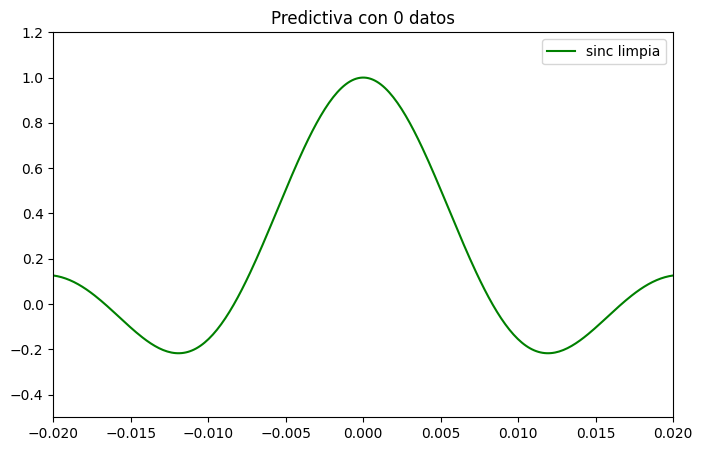

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from scipy.stats import multivariate_normal as mn
from sklearn.metrics import mean_squared_error
from skopt import gp_minimize
from skopt.space import Integer, Real

# ==============================
# 1. Generar datos sinc + ruido
# ==============================
f0 = 60
N = 300
t_axis = np.linspace(-0.02, 0.02, N)   # eje temporal

# señal sinc limpia
y_clean = np.sin(2*np.pi*f0*t_axis)/(2*np.pi*f0*t_axis)
y_clean[t_axis==0] = 1   # corregir singularidad

# Ruido Gaussiano Blanco
noise_power = 0.02
y_noisy = y_clean + np.sqrt(noise_power)*np.random.randn(N)

# ==============================
# 2. Funciones auxiliares
# ==============================
def make_design_matrix(t, deg):
    t_scaled = t / np.max(np.abs(t))
    return np.vstack([t_scaled**d for d in range(deg+1)]).T

def posterior_update(X, t, sig_eta, sig_w, tol=1e-10):
    lambdaR = sig_eta/sig_w
    SNinv = X.T.dot(X) + lambdaR*np.eye(X.shape[1])
    val, vec = np.linalg.eigh(SNinv)
    ind = val > tol
    SN = vec[:,ind].dot(np.diag(1/val[ind])).dot(vec[:,ind].T)
    mN = np.squeeze(SN.dot(X.T.dot(t)))
    return mN, SN

def predict_update(Xnew, mN, SN, sig_eta):
    mnew = Xnew.dot(mN)
    signew = np.diag(sig_eta*np.eye(Xnew.shape[0]) + Xnew.dot(SN).dot(Xnew.T))
    return mnew, signew

# ==============================
# 3. Optimización bayesiana
# ==============================
def objective(params):
    deg, log_sig_w, log_sig_eta = params
    sig_w = 10**log_sig_w
    sig_eta = 10**log_sig_eta

    # diseño polinomial
    X = make_design_matrix(t_axis, deg)
    # posterior
    mN, SN = posterior_update(X, y_noisy, sig_eta, sig_w)
    # predicción
    y_pred, _ = predict_update(X, mN, SN, sig_eta)
    # error
    return mean_squared_error(y_clean, y_pred)

search_space = [
    Integer(3, 15, name="deg"),         # polinomios
    Real(-3, 0, name="log_sig_w"),      # sig_w ~ [1e-3, 1]
    Real(-3, 0, name="log_sig_eta"),    # sig_eta ~ [1e-3, 1]
]

res = gp_minimize(objective, search_space, n_calls=30, random_state=42)

best_deg, best_log_sig_w, best_log_sig_eta = res.x
best_sig_w = 10**best_log_sig_w
best_sig_eta = 10**best_log_sig_eta

print(f"Mejores hiperparámetros encontrados:")
print(f"  Grado polinómico (deg): {best_deg}")
print(f"  sig_w: {best_sig_w:.4f}")
print(f"  sig_eta: {best_sig_eta:.4f}")
print(f"  MSE mínimo: {res.fun:.6f}")

# ==============================
# 4. Animación con hiperparámetros óptimos
# ==============================
X_full = make_design_matrix(t_axis, best_deg)
mN_full, SN_full = posterior_update(X_full, y_noisy, best_sig_eta, best_sig_w)

# Random indices for animation
ind = np.random.permutation(N)

def update(i):
    ax.clear()
    if i > 0:
        Xtrain = X_full[ind[:i]]
        ytrain = y_noisy[ind[:i]]
        mN, SN = posterior_update(Xtrain, ytrain, best_sig_eta, best_sig_w)
        y_pred, y_var = predict_update(X_full, mN, SN, best_sig_eta)

        ax.plot(t_axis, y_clean, 'g', label="sinc limpia")
        ax.scatter(t_axis[ind[:i]], y_noisy[ind[:i]], c='r', s=10, label="datos")
        ax.plot(t_axis, y_pred, 'b', label="media pred.")
        ax.fill_between(t_axis, y_pred-2*np.sqrt(y_var), y_pred+2*np.sqrt(y_var), alpha=0.3)
        ax.set_xlim([-0.02, 0.02])
        ax.set_ylim([-0.5, 1.2])
        ax.set_title(f"Predictiva con {i} datos")
        ax.legend()
    else:
        ax.plot(t_axis, y_clean, 'g', label="sinc limpia")
        ax.set_xlim([-0.02, 0.02])
        ax.set_ylim([-0.5, 1.2])
        ax.set_title(f"Predictiva con 0 datos")
        ax.legend()


fig, ax = plt.subplots(figsize=(8,5))
frames = [0, 5, 20, 50, 100, 200, 300]
anim = animation.FuncAnimation(fig, update, frames=frames, blit=False)
rc('animation', html='jshtml')
anim

##California Housing

In [7]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
print(housing.data.shape, housing.target.shape)
print(housing.feature_names[0:6])

(20640, 8) (20640,)
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']


##Prediccion de cada feature vs precio de la casa

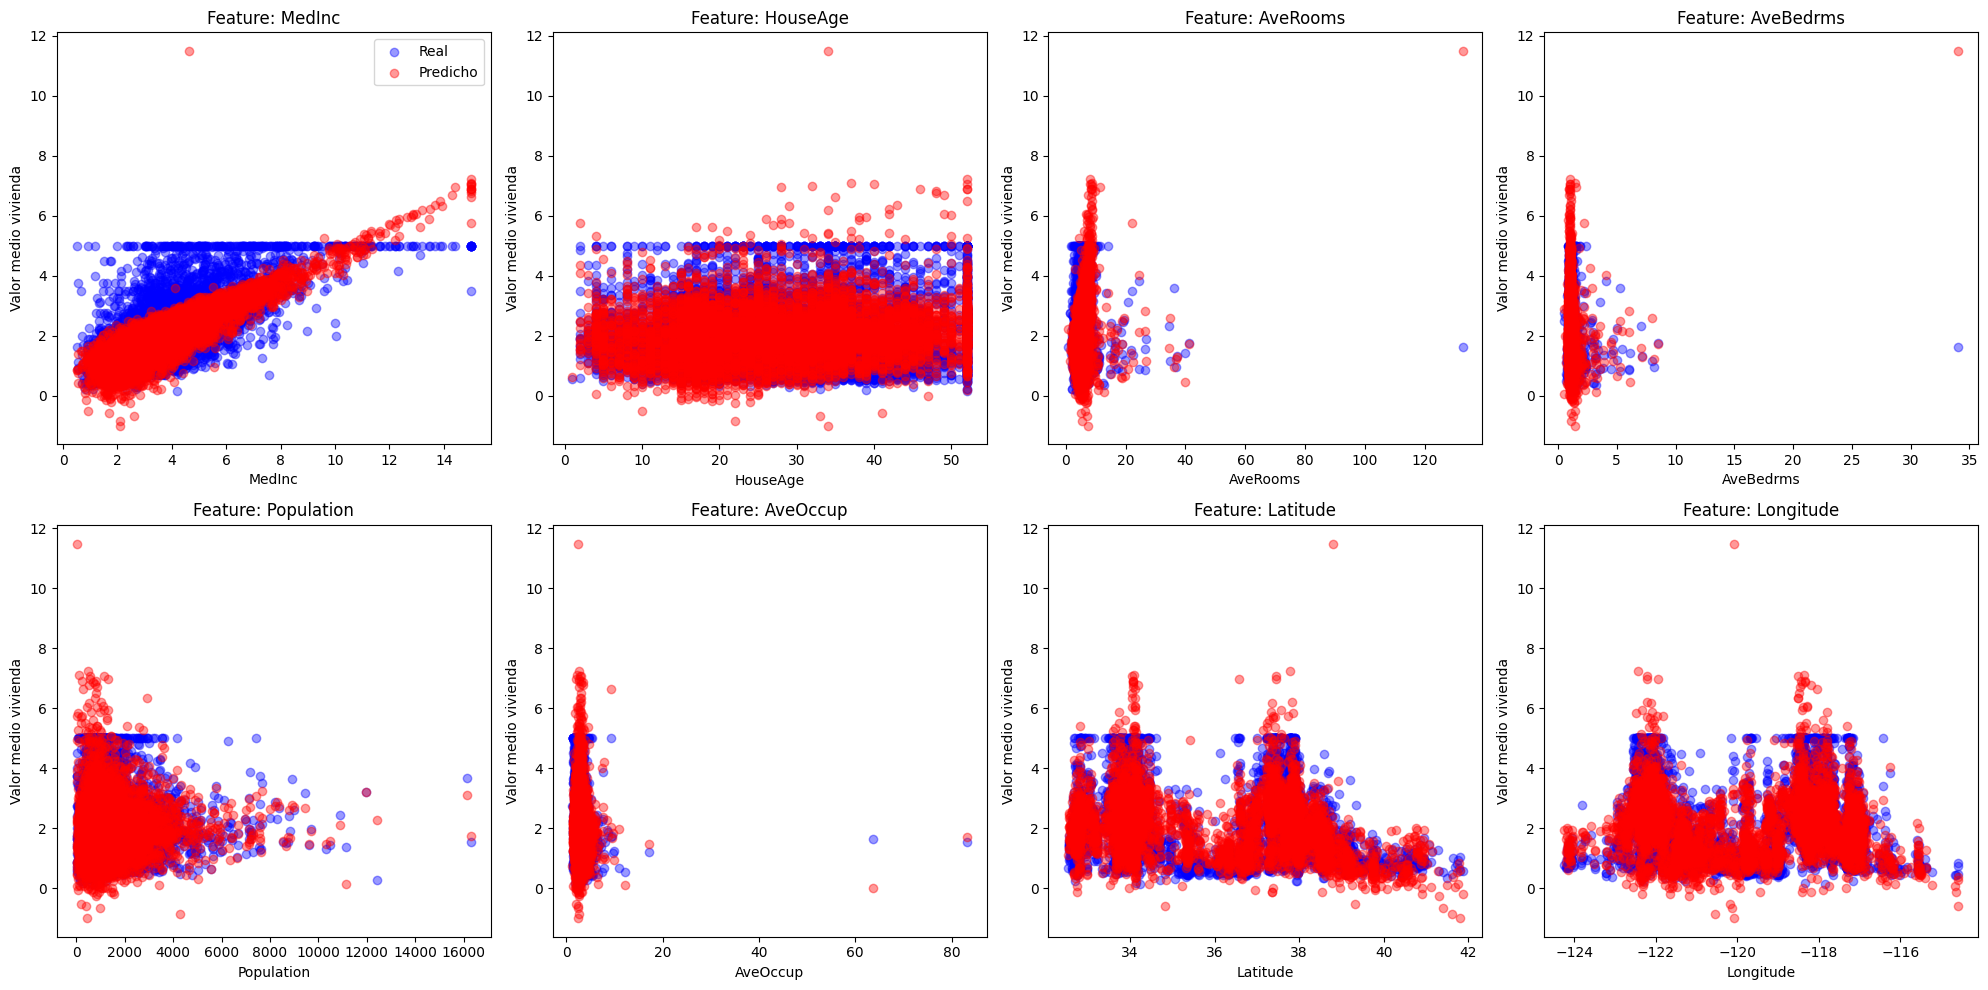

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge

# ======= CARGAR DATOS =======
housing = fetch_california_housing()
X, y = housing.data, housing.target
feature_names = housing.feature_names

# ======= TRAIN/TEST SPLIT =======
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ======= ESCALADO =======
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ======= REGRESIÓN BAYESIANA =======
model = BayesianRidge()
model.fit(X_train_scaled, y_train)

# Predicciones en test
y_pred = model.predict(X_test_scaled)

# ======= GRAFICAR =======
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()  # aplanar para iterar fácilmente

for i in range(X.shape[1]):
    ax = axes[i]
    ax.scatter(X_test[:, i], y_test, alpha=0.4, label="Real", color="blue")
    ax.scatter(X_test[:, i], y_pred, alpha=0.4, label="Predicho", color="red")
    ax.set_xlabel(feature_names[i])
    ax.set_ylabel("Valor medio vivienda")
    ax.set_title(f"Feature: {feature_names[i]}")

# Solo agregar la leyenda una vez
axes[0].legend()
plt.tight_layout()
plt.show()


##Comparación entre valores reales y predicciones bayesianas

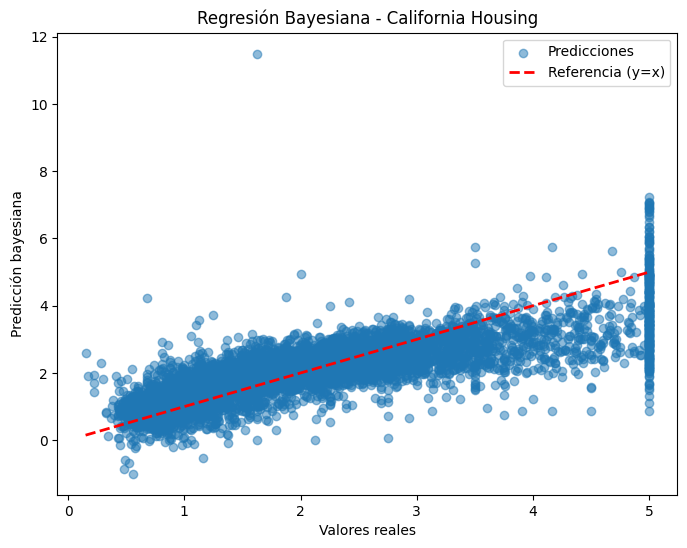

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge

# 1. Cargar dataset
housing = fetch_california_housing()
X, y = housing.data, housing.target

# 2. Dividir en train (70%) y test (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 3. Normalizar features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 4. Modelo de regresión bayesiana
model = BayesianRidge()
model.fit(X_train, y_train)

# 5. Predicciones con el conjunto de prueba
y_pred, y_std = model.predict(X_test, return_std=True)

# 6. Graficar resultados
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predicciones")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2, label="Referencia (y=x)")
plt.xlabel("Valores reales")
plt.ylabel("Predicción bayesiana")
plt.title("Regresión Bayesiana - California Housing")
plt.legend()
plt.show()


##Relación de cada feature con el precio de la casa

Correlaciones con el precio de la casa:
MedInc        0.688075
AveRooms      0.151948
HouseAge      0.105623
AveOccup     -0.023737
Population   -0.024650
Longitude    -0.045967
AveBedrms    -0.046701
Latitude     -0.144160
Name: Target, dtype: float64


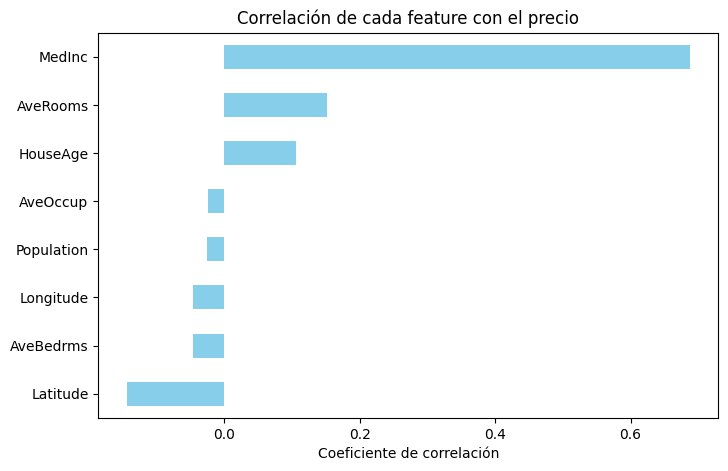

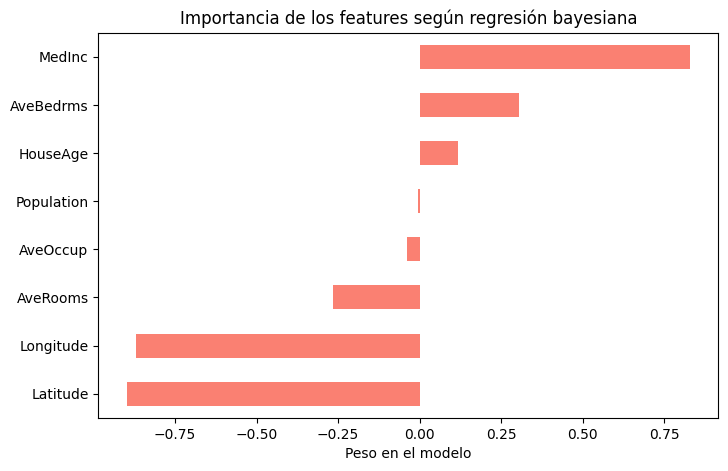

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler

# Cargar dataset
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = housing.target

# ---------- 1. Correlación de cada feature con el precio ----------
correlaciones = X.join(pd.Series(y, name="Target")).corr()["Target"].drop("Target")
print("Correlaciones con el precio de la casa:")
print(correlaciones.sort_values(ascending=False))

plt.figure(figsize=(8,5))
correlaciones.sort_values().plot(kind="barh", color="skyblue")
plt.title("Correlación de cada feature con el precio")
plt.xlabel("Coeficiente de correlación")
plt.show()

# ---------- 2. Importancia usando regresión bayesiana ----------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = BayesianRidge()
model.fit(X_scaled, y)

importancias = pd.Series(model.coef_, index=housing.feature_names)

plt.figure(figsize=(8,5))
importancias.sort_values().plot(kind="barh", color="salmon")
plt.title("Importancia de los features según regresión bayesiana")
plt.xlabel("Peso en el modelo")
plt.show()
